## 01. Predict alternative production pathways

In [1]:
#call load_model
%run 00load_model.ipynb

In [2]:
#define biomass as the objective function 
model.objective = model.reactions.BIOMASS_SCO_tRNA
model

Name,Sco_GEM_v1_3_1
Memory address,0x02db4bacc4f0
Number of metabolites,2064
Number of reactions,2599
Number of groups,7
Objective expression,1.0*BIOMASS_SCO_tRNA - 1.0*BIOMASS_SCO_tRNA_reverse_d3620
Compartments,"Cytoplasm, Extracellular"


### Simulation for maximum growth - objective function: BIOMASS_SCO_tRNA 

In [3]:
from optlang.interface import SOLUTION_LIMIT
solution = model.optimize()
solution

,fluxes,reduced_costs
BIOMASS_SCO,0.000000,-2.006862e+00
BIOMASS_SCO_tRNA,0.074617,-5.329071e-15
CARBOHYDRATE_PSEUDO,0.074617,0.000000e+00
CELL_WALL_PSEUDO,0.074617,2.775558e-17
DNA_PSEUDO,0.074617,-3.469447e-18
...,...,...
EX_xyl__D_e,0.000000,-1.722884e-01
EX_xylb_e,0.000000,0.000000e+00
EX_xylt_e,0.000000,-1.773392e-01
EX_ycpk_e,0.000000,0.000000e+00


We can see the optimal solution has a value of 0.075.

In [4]:
#check if our model has the production of undecylprodigiosin 
for m in model.reactions:
    if "undecylprodigiosin synthase" in m.name.lower():
        print("Enzyme description: ", m.name,"\n","Reaction", m, "\n")

Enzyme description:  undecylprodigiosin synthase 
 Reaction REDS37: atp_c + h2o_c + mbc_c + up_c --> amp_c + 2.0 h_c + 2.0 pi_c + red_c 



In [5]:
#check the fluxes that have values different than 0
solution.fluxes[solution.fluxes != 0.]

BIOMASS_SCO_tRNA       0.074617
CARBOHYDRATE_PSEUDO    0.074617
CELL_WALL_PSEUDO       0.074617
DNA_PSEUDO             0.074617
LIPID_PSEUDO           0.074617
                         ...   
EX_ni2_e              -0.000027
EX_o2_e               -1.727388
EX_pi_e               -0.073858
EX_so4_e              -0.019368
EX_zn2_e              -0.000028
Name: fluxes, Length: 713, dtype: float64

In [6]:
#check if there is consumption or production of undecylprodigiosin 
solution.fluxes["REDS37"]

0.0

### Simulation for maximum production - objective function: REDS37

In [7]:
#create two lists for a plot
undepro_flux = list()      #undecylprodigiosin
biomass_flux = list()

print("Fluxes in mmol / [gDW h] (concentration per gram dry weight of cells and hour)", "\n")
with model:
    
    #loop to check different values of lower bounds for biomass formation
    i = 0.01
    while i < 0.075:
        model.reactions.BIOMASS_SCO_tRNA.lower_bound = i 
        model.objective = model.reactions.DM_RED_c
        solution = model.optimize()
        biomass_flux.append(round(solution.fluxes.BIOMASS_SCO_tRNA,3))
        undepro_flux.append(round(solution.fluxes.DM_RED_c,3))
        print(f'Lower bound:{round(i,3)} - Biomass: {round(solution.fluxes.BIOMASS_SCO_tRNA,3)} - Undecylprodigiosin: {round(solution.fluxes.DM_RED_c,3)}')
        
        i += 0.005

Fluxes in mmol / [gDW h] (concentration per gram dry weight of cells and hour) 

Lower bound:0.01 - Biomass: 0.01 - Undecylprodigiosin: 0.114
Lower bound:0.015 - Biomass: 0.015 - Undecylprodigiosin: 0.105
Lower bound:0.02 - Biomass: 0.02 - Undecylprodigiosin: 0.097
Lower bound:0.025 - Biomass: 0.025 - Undecylprodigiosin: 0.088
Lower bound:0.03 - Biomass: 0.03 - Undecylprodigiosin: 0.079
Lower bound:0.035 - Biomass: 0.035 - Undecylprodigiosin: 0.07
Lower bound:0.04 - Biomass: 0.04 - Undecylprodigiosin: 0.061
Lower bound:0.045 - Biomass: 0.045 - Undecylprodigiosin: 0.053
Lower bound:0.05 - Biomass: 0.05 - Undecylprodigiosin: 0.044
Lower bound:0.055 - Biomass: 0.055 - Undecylprodigiosin: 0.035
Lower bound:0.06 - Biomass: 0.06 - Undecylprodigiosin: 0.026
Lower bound:0.065 - Biomass: 0.065 - Undecylprodigiosin: 0.017
Lower bound:0.07 - Biomass: 0.07 - Undecylprodigiosin: 0.008


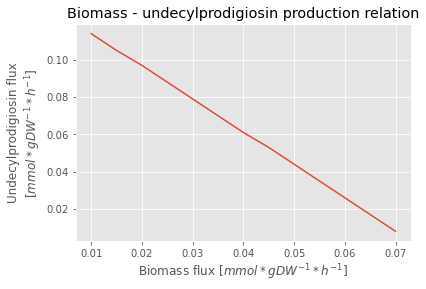

In [8]:
fig, ax = plt.subplots();
ax.plot(biomass_flux, undepro_flux); 

ax.set_title('Biomass - undecylprodigiosin production relation');
ax.set_xlabel('Biomass flux $[mmol*gDW^{-1}*h^{-1}]$');
ax.set_ylabel('Undecylprodigiosin flux\n$[mmol*gDW^{-1}*h^{-1}]$');

In [9]:
with model:
    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()
    print('Biomass flux (mmol / [gDW h]):',solution.fluxes.BIOMASS_SCO_tRNA)
    print('Undecylprodigiosin flux (mmol / [gDW h]):',round(solution.fluxes.DM_RED_c,3))
    print('Glucose uptake (mmol / [gDW h]:',solution.fluxes.EX_glc__D_e)

Biomass flux (mmol / [gDW h]): 0.045
Undecylprodigiosin flux (mmol / [gDW h]): 0.053
Glucose uptake (mmol / [gDW h]: -0.8


In [10]:
  with model:
  
    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()
    print("Maximum biomass productivity:", solution.fluxes["BIOMASS_SCO_tRNA"], "mmol / [gDW h]")
    
    gluc_ex_flux = model.reactions.EX_glc__D_e.flux
    max_yield = solution.fluxes["REDS37"] / (-1*gluc_ex_flux)

    print("Maximum undecylprodigiosin productivity =", round(solution.fluxes["REDS37"],3), "mmol / [gDW h]")
    print("Maximum yield =", round(max_yield,3), "mmol / [gDW h]")

Maximum biomass productivity: 0.045 mmol / [gDW h]
Maximum undecylprodigiosin productivity = 0.053 mmol / [gDW h]
Maximum yield = 0.066 mmol / [gDW h]


### Assessment of carbon sources

In [11]:
carbon_sources = []

for reaction in model.exchanges:
    for metabolite in reaction.metabolites:
        if 'C' in metabolite.elements:
            carbon_sources.append(reaction)

with model:
    model.objective = model.reactions.DM_RED_c
    threshold = model.slim_optimize(error_value=0.0)

solution_dict = {}

for cs in carbon_sources:
    with model:
        medium = model.medium
        medium['EX_glc__D_e'] = 0 # remove glucose from medium
        medium[cs.id] = 0.8 # add carbon source to medium
        model.medium = medium
        model.objective = model.reactions.DM_RED_c
        solution = model.slim_optimize(error_value=0.0)

        if solution > threshold:
            solution_dict[cs.id] = solution

print(f'The carbon sources that produce better results than glucose given that their uptake flux is 0.8 mmol/gDRW/h are:')
print('')
print(f'{"Carbon source":^42} | Production of antibiotic [mmol/gDW/h]')
print('-'*82)
for source, production in sorted(solution_dict.items(), key=lambda item: item[1], reverse=True):
    print(f'{list(model.reactions.get_by_id(source).metabolites)[0].name:>42} | {production:>6.3f}')

The carbon sources that produce better results than glucose given that their uptake flux is 0.8 mmol/gDRW/h are:

              Carbon source                | Production of antibiotic [mmol/gDW/h]
----------------------------------------------------------------------------------
Cellulose (chain length 500 glc_D assumed) | 72.603
                         Xylan (Oat spelt) | 64.308
                             Maltoheptaose |  1.027
                              Maltohexaose |  0.880
                        1,4-alpha-D-glucan |  0.880
                             Maltopentaose |  0.727
                             Maltotetraose |  0.580
                               Maltotriose |  0.432
                                 Raffinose |  0.426
                   N,N'-diacetylchitobiose |  0.363
                                Melibiitol |  0.289
                                 Trehalose |  0.284
                                   Maltose |  0.284
                              Epimelibiose |

### Trying growth in aerobic and anaerobic conditions

In [12]:
with model: 
    print("Areobic conditions")

    model.objective = model.reactions.BIOMASS_SCO_tRNA
    solution = model.optimize()

    print("Oxygen in the medium:", model.medium["EX_o2_e"])
    print("Oxygen Exchange reaction:", round(solution.fluxes["EX_o2_e"],3))
    print("Biomass flux:", round(solution.fluxes.BIOMASS_SCO_tRNA,3))           #model.slim_optimize() can be used to perform optimization without creating a solution
    print("Prodigiosin flux: ", round(solution.fluxes.DM_RED_c,3))
    print("Reactions with flux different than 0:",len(solution.fluxes[solution.fluxes != 0.]))

Areobic conditions
Oxygen in the medium: 1000.0
Oxygen Exchange reaction: -1.727
Biomass flux: 0.075
Prodigiosin flux:  0.0
Reactions with flux different than 0: 764


In [13]:
with model:
    anaerobic_medium = model.medium
    anaerobic_medium["EX_o2_e"] = 0.0
    model.medium = anaerobic_medium

    model.objective = model.reactions.BIOMASS_SCO_tRNA
    solution = model.optimize()

    print("Anaereobic conditions")
    print("Oxygen in the medium:", anaerobic_medium["EX_o2_e"])
    print("Oxygen Exchange reaction:", round(solution.fluxes["EX_o2_e"],3))
    print("Biomass flux:", round(solution.fluxes.BIOMASS_SCO_tRNA,3))
    print("Prodigiosin flux:", round(solution.fluxes.DM_RED_c,3))
    print("Reactions with flux different than 0:",len(solution.fluxes[solution.fluxes != 0.]))

Anaereobic conditions
Oxygen in the medium: 0.0
Oxygen Exchange reaction: 0.0
Biomass flux: 0.0
Prodigiosin flux: 0.0
Reactions with flux different than 0: 103


In [14]:
#Find genes involved in the ability to grow without O2
model.genes.SCO0216 #narG2 #NO3R2
model.genes.SCO0217 #narH2
model.genes.SCO0218 #narJ2
model.genes.SCO0219 #narl2
model.genes.SCO4947 #narG3
model.genes.SCO4948 #narH3
model.genes.SCO4949 #narJ3
model.genes.SCO4950 #narl3
model.genes.SCO6532 #narl
model.genes.SCO6533 #narJ
model.genes.SCO6534 #narH
model.genes.SCO6535 #narG

model.reactions.NO3R2

Reaction identifier,NO3R2
Name,Nitrate reductase (menaquinol-9)
Memory address,0x2db7f0c3160
Stoichiometry,2.0 h_c + mql9_c + no3_c --> h2o_c + 2.0 h_e + mqn9_c + no2_c 2.0 H+ + Menaquinol 9 + Nitrate --> H2O + 2.0 H+ + Menaquinone 9 + Nitrite
GPR,(SCO0216 and SCO0217 and SCO0218 and SCO0219) or (SCO4947 and SCO4948 and SCO4949 and SCO4950) or...
Lower bound,0.0
Upper bound,1000.0


In [15]:
#Check if the reaction flux changes with the two different mediums
with model:
    model.objective = model.reactions.BIOMASS_SCO_tRNA
    solution = model.optimize()
    
    print("Areobic conditions")
    print("Oxygen in the medium:", model.medium["EX_o2_e"])
    print("Oxygen Exchange reaction:", round(solution.fluxes.EX_o2_e,3))
    print("NO3R3 flux:", solution.fluxes.NO3R2)           

    anaerobic_medium = model.medium
    anaerobic_medium["EX_o2_e"] = 0.0
    model.medium = anaerobic_medium
    model.objective = model.reactions.BIOMASS_SCO_tRNA
    solution = model.optimize()

    print("\nAnaereobic conditions")
    print("Oxygen in the medium:", anaerobic_medium["EX_o2_e"])
    print("Oxygen Exchange reaction:", round(solution.fluxes.EX_o2_e,3))
    print("NO3R3 flux:", solution.fluxes.NO3R2)

Areobic conditions
Oxygen in the medium: 1000.0
Oxygen Exchange reaction: -1.727
NO3R3 flux: 0.0

Anaereobic conditions
Oxygen in the medium: 0.0
Oxygen Exchange reaction: 0.0
NO3R3 flux: 0.0


### Alternative mediums

**Minimal medium**

Minimal medium was tested to see the changes in productivity and yield. In the minimal medium carbon dioxide (EX_co2_e), iron (EX_fe3_e), water (EX_h2o_e), sodium (EX_na2_e), protons (EX_h_e), and tungstate (EX_tungs_e) exchange reactions were inhibited. No alteration was found in either productivity or yield.


In [16]:
from cobra.medium import minimal_medium

#create minimal medium
max_growth = model.slim_optimize()
minimal_medium(model, max_growth)

EX_ca2_e        0.000429
EX_cl_e         0.000429
EX_cobalt2_e    0.000003
EX_cu2_e        0.000058
EX_fe2_e        0.001453
EX_glc__D_e     0.800000
EX_k_e          0.016078
EX_mg2_e        0.000715
EX_mn2_e        0.000057
EX_mobd_e       0.000003
EX_nh4_e        0.651820
EX_ni2_e        0.000027
EX_o2_e         1.727388
EX_pi_e         0.073858
EX_so4_e        0.019368
EX_zn2_e        0.000028
dtype: float64

In [30]:
with model:
    min_medium = minimal_medium(model, max_growth)
    model.medium = min_medium
    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()
    max_yield = solution.fluxes["REDS37"] / (-1*model.reactions.EX_glc__D_e.flux)

    print("Biomass productivity:", solution.fluxes["BIOMASS_SCO_tRNA"], "mmol / [gDW h]")
    print('Productivity of undecylprodigiosin =', round(solution.fluxes["REDS37"],3), "mmol / [gDW h]")
    print('Yield =', round(max_yield,3))

Biomass productivity: 0.045 mmol / [gDW h]
Productivity of undecylprodigiosin = 0.053 mmol / [gDW h]
Yield = 0.066


**R5 medium**

The R5 medium is composed of sucrose, potassium sulfate, magnesium chloride, glucose, casamino acids, and yeast extract. The amino acids were added to the medium and the productivity and yield were tested. Both showed a significant increase of 0.912 mmol / [gDW h] and a value of 1.14, respectively. Nevertheless, the exchange reaction from sucrose uptake was 0, meaning that the main carbon source was glucose. Moreover, the limitant reaction was the uptake of oxygen, followed by proton and glucose exchange reactions.

In [18]:
#first we define medium
R5_medium = model.medium
R5_medium['EX_o2_e']     = 10
R5_medium['EX_gly_e']    = 0.4
R5_medium['EX_sucr_e']   = 8
R5_medium['EX_glc__D_e'] = 0.8
R5_medium['EX_ala__L_e'] = 0.4
R5_medium['EX_arg__L_e'] = 0.4
R5_medium['EX_asp__L_e'] = 0.4
R5_medium['EX_cys__L_e'] = 0.4
R5_medium['EX_glu__L_e'] = 0.4
R5_medium['EX_his__L_e'] = 0.4
R5_medium['EX_ile__L_e'] = 0.4
R5_medium['EX_leu__L_e'] = 0.4
R5_medium['EX_lys__L_e'] = 0.4
R5_medium['EX_met__L_e'] = 0.4
R5_medium['EX_phe__L_e'] = 0.4
R5_medium['EX_pro__L_e'] = 0.4
R5_medium['EX_ser__L_e'] = 0.4
R5_medium['EX_thr__L_e'] = 0.4
R5_medium['EX_trp__L_e'] = 0.4
R5_medium['EX_tyr__L_e'] = 0.4
R5_medium['EX_val__L_e'] = 0.4

#trace element solution
R5_medium["EX_zn2_e"] = 0.4
R5_medium["EX_fe2_e"] = 0.4
R5_medium["EX_cu2_e"] = 0.4
R5_medium["EX_mn2_e"] = 0.4
R5_medium["EX_nh4_e"] = 0.4

#change boundaries of the other compounds
R5_medium["EX_ca2_e"]     = 0.4
R5_medium["EX_cl_e"]      = 0.4
R5_medium["EX_co2_e"]     = 0.4
R5_medium["EX_cobalt2_e"] = 0.4
R5_medium["EX_k_e"]       = 0.4
R5_medium["EX_mg2_e"]     = 0.4
R5_medium["EX_mobd_e"]    = 0.4
R5_medium["EX_ni2_e"]     = 0.4
R5_medium["EX_pi_e"]      = 0.4
R5_medium["EX_so4_e"]     = 0.4

In [25]:
with model:
    fluxes_R5 = []
    model.medium = R5_medium

    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()

    max_yield = solution.fluxes["REDS37"] / (-1*model.reactions.EX_glc__D_e.flux)
    print("Maximum biomass productivity:", solution.fluxes["BIOMASS_SCO_tRNA"], "mmol / [gDW h]")
    print('Maximum productivity of undecylprodigiosin =', round(solution.fluxes["REDS37"],3), "mmol / [gDW h]")
    print('Maximum yield =', round(max_yield,3))

    print("\nCheck fluxes that are not active:")
    for element in R5_medium:
        if solution.fluxes[element] == 0.:
            print(element, round(solution.fluxes[element],3))

    print("\nCheck limiting flux")
    for element in R5_medium:
        if solution.fluxes[element]!= 0.:
            fluxes_R5.append((element,round(solution.fluxes[element],3)))

    for flux, value in sorted(fluxes_R5, key = lambda element : element[1])[0:5]:
        print(flux,': ',value)

Maximum biomass productivity: 0.045 mmol / [gDW h]
Maximum productivity of undecylprodigiosin = 0.912 mmol / [gDW h]
Maximum yield = 1.14

Check fluxes that are not active:
EX_fe3_e 0.0
EX_na1_e 0.0
EX_tungs_e 0.0
EX_sucr_e 0.0

Check limiting flux
EX_o2_e :  -6.791
EX_h_e :  -4.682
EX_glc__D_e :  -0.8
EX_gly_e :  -0.4
EX_ala__L_e :  -0.4


**SFM**

The SFM medium is composed of mannitol, so the compound was added to the medium with an exchange reaction flux of 0.8. Again, the productivity and yield were tested for this medium. The productivity was seen to be 0.206 mmol/[gDW h] while the yield was 0,258. In this case, the exchange reaction for oxygen was the limiting reaction, followed by the uptake of NH4 and glucose / mannitol uptake. When glucose uptake was set to 0, the production fell to 0.058 mmol/[gDW h] and the yield to 0.073. 

In [20]:
SFM_medium = model.medium
SFM_medium["EX_mnl_e"] = 0.8
SFM_medium["EX_o2_e"] = 10
SFM_medium["EX_glc__D_e"] = 0.8
SFM_medium

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 0.8,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_o2_e': 10,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mnl_e': 0.8}

In [26]:
with model:
    fluxes_SFM = []
    model.medium = SFM_medium

    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()

    max_yield = solution.fluxes["REDS37"] / (-1*model.reactions.EX_mnl_e.flux)
    print("Maximum biomass productivity:", solution.fluxes["BIOMASS_SCO_tRNA"], "mmol / [gDW h]")
    print('Maximum productivity of undecylprodigiosin =', round(solution.fluxes["REDS37"],3), "mmol / [gDW h]")
    print('Maximum yield =', round(max_yield,3))

    print("\nCheck fluxes that are not active:")
    for element in SFM_medium:
        if solution.fluxes[element] == 0.:
            print(element, round(solution.fluxes[element],3))

    print("\nCheck limiting flux")
    for element in SFM_medium:
        if solution.fluxes[element]!= 0.:
            fluxes_SFM.append((element,round(solution.fluxes[element],3)))

    for flux, value in sorted(fluxes_SFM, key = lambda element : element[1])[0:5]:
        print(flux,': ',value)

Maximum biomass productivity: 0.045 mmol / [gDW h]
Maximum productivity of undecylprodigiosin = 0.206 mmol / [gDW h]
Maximum yield = 0.258

Check fluxes that are not active:
EX_fe3_e 0.0
EX_na1_e 0.0
EX_tungs_e 0.0

Check limitant flux:
EX_o2_e :  -1.757
EX_nh4_e :  -1.011
EX_glc__D_e :  -0.8
EX_mnl_e :  -0.8
EX_pi_e :  -0.045


**DSMZ**

The DSMZ medium is composed of malt extract (mixture of maltose and amino acids) and agar (galactose). All the components were added to the medium and the best productivity and yield were achieved this time. A productivity of 1.340 mmol/[gDW h] and a yield of 1.675.

In [29]:
malt_medium = model.medium
malt_medium["EX_malt_e"] = 0.8
malt_medium["EX_o2_e"] = 10
malt_medium["EX_gal_e"] = 0.8
malt_medium['EX_glc__D_e'] = 0.8
malt_medium['EX_ala__L_e'] = 0.4
malt_medium['EX_arg__L_e'] = 0.4
malt_medium['EX_asp__L_e'] = 0.4
malt_medium['EX_cys__L_e'] = 0.4
malt_medium['EX_glu__L_e'] = 0.4
malt_medium['EX_his__L_e'] = 0.4
malt_medium['EX_ile__L_e'] = 0.4
malt_medium['EX_leu__L_e'] = 0.4
malt_medium['EX_lys__L_e'] = 0.4
malt_medium['EX_met__L_e'] = 0.4
malt_medium['EX_phe__L_e'] = 0.4
malt_medium['EX_pro__L_e'] = 0.4
malt_medium['EX_ser__L_e'] = 0.4
malt_medium['EX_thr__L_e'] = 0.4
malt_medium['EX_trp__L_e'] = 0.4
malt_medium['EX_tyr__L_e'] = 0.4
malt_medium['EX_val__L_e'] = 0.4
malt_medium

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 0.8,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_o2_e': 10,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_malt_e': 0.8,
 'EX_gal_e': 0.8,
 'EX_ala__L_e': 0.4,
 'EX_arg__L_e': 0.4,
 'EX_asp__L_e': 0.4,
 'EX_cys__L_e': 0.4,
 'EX_glu__L_e': 0.4,
 'EX_his__L_e': 0.4,
 'EX_ile__L_e': 0.4,
 'EX_leu__L_e': 0.4,
 'EX_lys__L_e': 0.4,
 'EX_met__L_e': 0.4,
 'EX_phe__L_e': 0.4,
 'EX_pro__L_e': 0.4,
 'EX_ser__L_e': 0.4,
 'EX_thr__L_e': 0.4,
 'EX_trp__L_e': 0.4,
 'EX_tyr__L_e': 0.4,
 'EX_val__L_e': 0.4}

In [27]:
with model:
    fluxes_malt = []
    model.medium = malt_medium

    model.reactions.BIOMASS_SCO_tRNA.lower_bound = 0.045
    model.objective = model.reactions.DM_RED_c
    solution = model.optimize()

    max_yield = solution.fluxes["REDS37"] / (-1*model.reactions.EX_malt_e.flux)
    print("Maximum biomass productivity:", solution.fluxes["BIOMASS_SCO_tRNA"], "mmol / [gDW h]")
    print('Maximum productivity of undecylprodigiosin =', round(solution.fluxes["REDS37"],3), "mmol / [gDW h]")
    print('Maximum yield =', round(max_yield,3))

    print("\nCheck fluxes that are not active:")
    for element in malt_medium:
        if solution.fluxes[element] == 0.:
            print(element, round(solution.fluxes[element],3))

    print("\nCheck limiting flux")
    for element in malt_medium:
        if solution.fluxes[element]!= 0.:
            fluxes_malt.append((element,round(solution.fluxes[element],3)))

    for flux, value in sorted(fluxes_SFM, key = lambda element : element[1])[0:5]:
        print(flux,': ',value)

Maximum biomass productivity: 0.045 mmol / [gDW h]
Maximum productivity of undecylprodigiosin = 1.34 mmol / [gDW h]
Maximum yield = 1.675

Check fluxes that are not active:
EX_fe3_e 0.0
EX_na1_e 0.0
EX_tungs_e 0.0

Check limiting flux
EX_o2_e :  -1.757
EX_nh4_e :  -1.011
EX_glc__D_e :  -0.8
EX_mnl_e :  -0.8
EX_pi_e :  -0.045
